Reference paper (not my work) - https://arxiv.org/abs/1901.11103

Transformer model to learn the potential to density mapping

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt

In [19]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [176]:
potentials_dict = np.load('./data/Potentials.npz')
densities_dict = np.load('./data/Densities.npz')

In [177]:
potentials = potentials_dict['arr_0']
densities = densities_dict['arr_0']

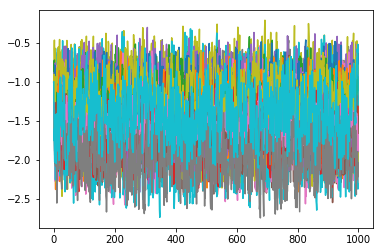

In [178]:
for i in range(len(potentials)):
    plt.plot(potentials[i])

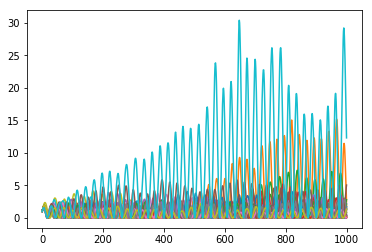

In [179]:
for i in range(len(densities)):
    plt.plot(densities[i])

In [6]:
class PosEncoder(nn.Module):
    def __init__(self):
        super(PosEncoder, self).__init__()
    
    def forward(self, X):
        enc = torch.zeros_like(X)
        for pos in range(X.shape[0]):
            for i in range(X.shape[1]):
                if i % 2 == 0:
                    enc[pos][i] = np.sin(pos/10000**(2*i/X.shape[1]))
                else:
                    enc[pos][i] = np.cos(pos/10000**(2*i/X.shape[1]))
        X += enc
        return X

In [315]:
class Attention(nn.Module):
    def __init__(self):
        super(Attention, self).__init__()
        self.softmax = nn.Softmax(dim = 1)
    
    def forward(self, Q, K, V, mask):
        assert Q.shape == K.shape
        assert K.shape == V.shape
        assert mask.shape == torch.Size([Q.shape[0], Q.shape[0]])
        d = Q.shape[1]
        out = (1/np.sqrt(d))*torch.matmul(Q, torch.transpose(K, 0, 1))
        out = self.softmax(out*mask)
        out = torch.matmul(out, V)
        return out
        

In [316]:
class MultiHeadAttention(nn.Module):
    def __init__(self, d, n_heads):
        super(MultiHeadAttention, self).__init__()
        self.d = d
        self.dk = d//n_heads
        self.n_heads = n_heads
        self.Lq = nn.ModuleList([nn.Linear(d, self.dk) for i in range(n_heads)])
        self.Lk = nn.ModuleList([nn.Linear(d, self.dk) for i in range(n_heads)])
        self.Lv = nn.ModuleList([nn.Linear(d, self.dk) for i in range(n_heads)])
        self.Lo = nn.Linear(self.dk*self.n_heads, self.d)
        self.attn = nn.ModuleList([Attention() for i in range(n_heads)])
        
    def forward(self, Q, K, V, mask):
        Qp = [self.Lq[i](Q) for i in range(self.n_heads)]
        Kp = [self.Lk[i](K) for i in range(self.n_heads)]
        Vp = [self.Lv[i](V) for i in range(self.n_heads)]
        heads = [self.attn[i](Qp[i], Kp[i], Vp[i], mask) for i in range(self.n_heads)]
        out = self.Lo(torch.cat(heads, dim = 1))
        return out
        

In [317]:
class FFNet(nn.Module):
    def __init__(self, d, dff):
        super(FFNet, self).__init__()
        self.L1 = nn.Linear(d, dff)
        self.L2 = nn.Linear(dff, d)
    
    def forward(self, X):
        out = self.L2(F.relu(self.L1(X)))
        return out

In [318]:
class EncoderLayer(nn.Module):
    def __init__(self, d, n_heads, dff):
        super(EncoderLayer, self).__init__()
        self.attn = MultiHeadAttention(d, n_heads)
        self.ln1 = nn.LayerNorm(d)
        self.ffn = FFNet(d, dff)
        self.ln2 = nn.LayerNorm(d)
        
    def forward(self, X):
        out = self.ln1(X + self.attn(X, X, X, torch.ones(X.shape[0], X.shape[0])))
        out = self.ln2(out + self.ffn(out))
        return out  

In [319]:
class Encoder(nn.Module):
    def __init__(self, d, n_heads, dff, n_layers):
        super(Encoder, self).__init__()
        self.layers = nn.ModuleList([EncoderLayer(d, n_heads, dff) for i in range(n_layers)])
    
    def forward(self, X):
        out = self.layers[0](X)
        for i in range(1, len(self.layers)):
            out = self.layers[i](out)
        return out

In [380]:
class DecoderLayer(nn.Module):
    def __init__(self, d, n_heads, dff):
        super(DecoderLayer, self).__init__()
        self.attn1 = MultiHeadAttention(d, n_heads)
        self.attn2 = MultiHeadAttention(d, n_heads)
        self.ln1 = nn.LayerNorm(d)
        self.ffn = FFNet(d, dff)
        self.ln2 = nn.LayerNorm(d)
        self.ln3 = nn.LayerNorm(d)
        
    def forward(self, X, enc_out):
        mask = torch.ones(X.shape[0], X.shape[0])
        for i in range(X.shape[0]):
            for j in range(i, X.shape[0]):
                mask[i][j] = -1e20
        out = self.ln1(X + self.attn1(X, X, X, mask))
        mask = torch.ones(X.shape[0], X.shape[0])
        out = self.ln2(out + self.attn2(out, enc_out, enc_out, mask))
        out = self.ln3(out + self.ffn(out))
        return out  

In [381]:
class Decoder(nn.Module):
    def __init__(self, input_size, d, n_heads, dff, n_layers):
        super(Decoder, self).__init__()
        self.layers = nn.ModuleList([DecoderLayer(d, n_heads, dff) for i in range(n_layers)])
        self.L = nn.Linear(d, input_size)
    
    def forward(self, X, enc_out):
        out = self.layers[0](X, enc_out)
        for i in range(1, len(self.layers)):
            out = self.layers[i](out, enc_out)
        out = self.L(out)
        return out 

In [382]:
class Transformer(nn.Module):
    def __init__(self, input_size, d, n_heads, dff, n_layers):
        super(Transformer, self).__init__()
        self.pos_enc = PosEncoder()
        self.enc = Encoder(d, n_heads, dff, n_layers)
        self.dec = Decoder(input_size, d, n_heads, dff, n_layers)
    
    def forward(self, X, Y=None):
        enc_out = self.enc(self.pos_enc(X))
        if Y is not None:
            out = self.dec(self.pos_enc(Y), enc_out)
        else:
            out = self.dec(self.pos_enc(enc_out), enc_out)
        return out

In [447]:
batch_size = 100
d = 8
input_size = 1
n_heads = 4
dff = 64
n_layers = 6
model = Transformer(input_size, d, n_heads, dff, n_layers)
# model.to(device)

In [448]:
X = torch.zeros(batch_size, d)
Y = torch.zeros(batch_size, d)
for i in range(batch_size):
    X[i] = torch.tensor([potentials[0][i]**j for j in range(1, d + 1)], dtype = torch.float)
    Y[i] = torch.tensor([densities[0][i + 1]**j for j in range(1, d + 1)], dtype = torch.float)
# X = X.to(device)
# Y = Y.to(device)

In [449]:
X.size()

torch.Size([100, 8])

In [450]:
criterion = nn.MSELoss()
out = model(X, Y)
loss = criterion(out, Y[:,0])
print(out.shape)
print(loss)

torch.Size([100, 1])
tensor(1.7389, grad_fn=<MseLossBackward>)


In [451]:
n_seq = len(potentials)
seq_len = len(potentials[0])
n_train = 25

In [452]:
X_train = np.array([potentials[i][j*batch_size:(j + 1)*batch_size] for i in range(n_train) for j in range(1, seq_len//batch_size)])
X_train.shape

(225, 100)

In [453]:
Y_train = np.array([densities[i][j*batch_size:(j + 1)*batch_size] for i in range(n_train) for j in range(1, seq_len//batch_size)])
Y_train.shape

(225, 100)

In [454]:
def get_batch(X_train, Y_train, d):
    batch_size = X_train.shape[1] 
    x = torch.zeros((batch_size, d))
    y = torch.zeros((batch_size, d))
    idx = np.random.randint(0, X_train.shape[0])
    for i in range(batch_size):
        x[i] = torch.tensor([X_train[idx][i]**j for j in range(1, d + 1)])
        y[i] = torch.tensor([Y_train[idx][i]**j for j in range(1, d + 1)])
    return (x, y)    

In [455]:
x, y = get_batch(X_train, Y_train, d)
print(x.shape, y.shape)

torch.Size([100, 8]) torch.Size([100, 8])


In [456]:
model = Transformer(input_size, d, n_heads, dff, n_layers)
# model.to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay = 0)
# optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
criterion = nn.MSELoss()
loss_vals = []
n_iters = X_train.shape[0]

In [464]:
epochs = 10
avg_loss = 0
for e in range(epochs):
    avg_loss = 0
    for i in range(n_iters):
        data, target = get_batch(X_train, Y_train, d)
#         data = data.to(device)
#         target = target.to(device)
        out = model(data, target)
        optimizer.zero_grad()
        loss = criterion(out, target[:,0])
        loss.backward()
        loss_vals.append(loss.item())
        avg_loss += loss_vals[-1]
        optimizer.step()
        
    avg_loss /= len(X_train)
    print('Epoch = {}, avg loss = {:.3}'.format(e, avg_loss))

Epoch = 0, avg loss = 2.49
Epoch = 1, avg loss = 1.75
Epoch = 2, avg loss = 2.4
Epoch = 3, avg loss = 1.54
Epoch = 4, avg loss = 1.87
Epoch = 5, avg loss = 2.05
Epoch = 6, avg loss = 1.88
Epoch = 7, avg loss = 1.71
Epoch = 8, avg loss = 1.71
Epoch = 9, avg loss = 1.85


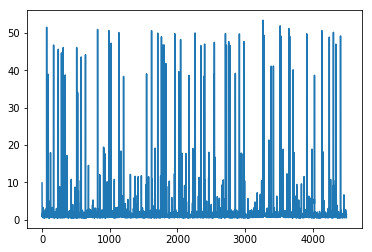

In [465]:
plt.plot(loss_vals)

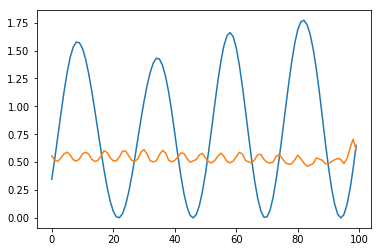

In [469]:
data, target = get_batch(X_train, Y_train, d)
# data = data.to(device)
out = model(data)

plt.figure()
plt.plot(target[:,0].numpy())
plt.plot(out.detach().numpy())

In [103]:
out.shape

torch.Size([150, 1])

In [104]:
target.shape

torch.Size([150, 5])